# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)



In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [ ]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [ ]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [ ]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [ ]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [ ]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [ ]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [ ]:
train_coronal_data[0]

'0415.npy'

In [ ]:
train_coronal_dir

'data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 
<br> Unfortunately, when using a pretrained model, one is limited by input_shape. For VGG16, it should be (224, 244, 3), or (3, 224, 224). It should be in 4D tensor with shape (batch_shape, conv_dim1, conv_dim2, channel).

In [ ]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130, 256, 256, 3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [ ]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [ ]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [ ]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [ ]:
image = np.load('data/train_transform/sagittal.npy')

In [ ]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [ ]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [ ]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [ ]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [ ]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [ ]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from extracted dataset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [ ]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


## Utilising pretrained model

### AlexNet
The below is adapted from [AlexNet](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/) which won the 2012 ImageNet LSVRC-2012 competition, and which was also the primary building block for the Stanford group that analysed this data. It is a lot 'smaller', with reduced number of filters and neurons in the connected layers to minimise overfitting.
<br>
<br> Added 'same' padding, so that output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad. 
<br>
<br> BatchNormalisation layer was added because it would accelerate the training process, while offering similar classification accuracy and provide a modest form of regularization. I did test the kernel_regularizer. l2 (sum of squared weights) were initially tested because it was the most common type (with values in the log scale), and reasonable values of lambda range between 0 and 0.1 (Applied Predictive Modeling, 2013). However, after trying several values, it was found that a value between '1e-7' or '1e-8' would enable some training longer than 1 epoch, but it was still a very small value. It was later removed since BatchNormalization seemed to be sufficient in providing *some* regularization, and it was further found that normalisation together with regularisation has no effect on regularising the network ([Laarhoven 2017](https://arxiv.org/pdf/1706.05350.pdf)).
<br>
<br> 'sgd' was used so that the learning rate is slow, and '1e-4' was good. Too high and it was overfitting/ underfitting within 1 epoch.  

In [ ]:
def create_model():
    '''this function creates the model adapted from alexnet'''
    # instantiate
    cnn_model = Sequential()

    # 1st layer
    cnn_model.add(Conv2D(filters = 6,             # number of filters
                         kernel_size = (11, 11),   # height/width of filter
                         activation='relu',        # activation function 
                         input_shape=(256,256,3),  # shape of input (image)
                         strides=(4,4),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 
    
    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 2nd layer
    cnn_model.add(Conv2D(filters = 16,             
                         kernel_size = (5, 5),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 3rd layer
    cnn_model.add(Conv2D(filters = 32,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # 4th layer
    cnn_model.add(Conv2D(filters = 64,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # 5th layer
    cnn_model.add(Conv2D(filters = 32,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         padding='same')) 
    cnn_model.add(BatchNormalization())

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))
    
    # flatten from box to vertical line of nodes!
    cnn_model.add(Flatten())
    
    # 1st fully connected layer
    cnn_model.add(Dense(16, activation='relu'))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))
    
    # 2nd fully connected layer
    cnn_model.add(Dense(8, activation='relu'))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))
    
    # Add a final layer with 1 neuron.
    cnn_model.add(Dense(1, activation='sigmoid')) 
    
    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Compile model 
    cnn_model.compile(loss='binary_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

    return cnn_model


In [ ]:
model = create_model()
model.summary()


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_175 (Conv2D)          (None, 64, 64, 6)         2184      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 32, 32, 16)        2416      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 16, 16, 32)      

In [ ]:
for layer in model.layers:
    layer.trainable = True
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,conv2d_175,True
1,max_pooling2d_105,True
2,conv2d_176,True
3,max_pooling2d_106,True
4,conv2d_177,True
5,conv2d_178,True
6,conv2d_179,True
7,batch_normalization_28,True
8,max_pooling2d_107,True
9,flatten_35,True


In [ ]:
def build_model(model,model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function builds and runs the model'''
    path_dir = '/content/drive/MyDrive' 
    weights_path = f'{path_dir}/{model_name}/alexnet_weights.h5'
    checkpoint_path = f'{path_dir}/{model_name}//alexnet_model.h5'

    model.save_weights(weights_path)
        
    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)],                
            verbose=1)
    
    return model, history

batch_size at 32 was good. Too high, and the accuracy was fluctuating too much. patience was kept at 2, due to  overfitting very early during training. So it was better to stop it early, rather than have a higher value for patience. 

Epoch 1/20
36/36 [==============================] - 2s 39ms/step - loss: 1.0660 - accuracy: 0.5513 - val_loss: 0.8477 - val_accuracy: 0.4583
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7721 - accuracy: 0.6336 - val_loss: 0.7826 - val_accuracy: 0.5250
Epoch 3/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7675 - accuracy: 0.6389 - val_loss: 0.7701 - val_accuracy: 0.5667
Epoch 4/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7662 - accuracy: 0.6389 - val_loss: 0.7666 - val_accuracy: 0.5833
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7669 - accuracy: 0.6416 - val_loss: 0.7670 - val_accuracy: 0.5667
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7637 - accuracy: 0.6434 - val_loss: 0.7675 - val_accuracy: 0.5583


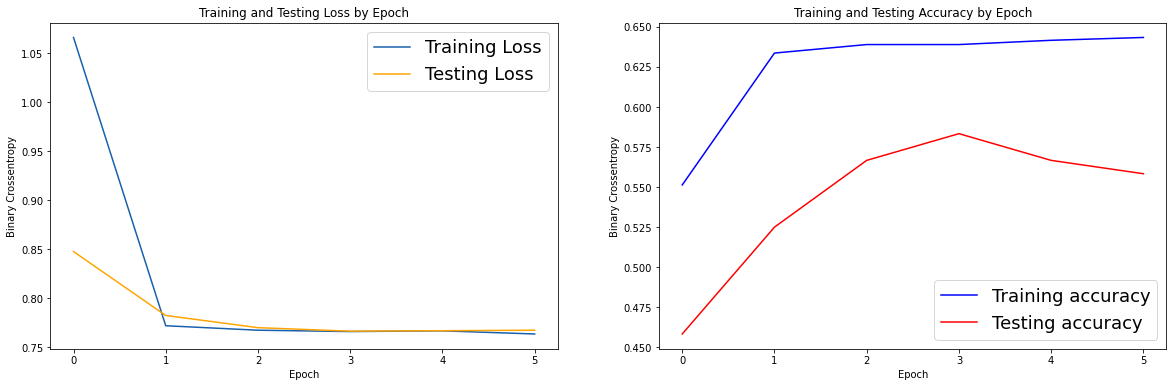

In [ ]:
# coronal plane
num_epochs=20

cnn_model=create_model()
cor_men_model, alex_cor_men = build_model(cnn_model,'alex_cor_men', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
alex_cor_men_acc=[]
alex_cor_men_acc.append(np.mean(alex_cor_men.history['val_accuracy']))
plot_results(alex_cor_men)

Epoch 1/20
36/36 [==============================] - 2s 31ms/step - loss: 0.9053 - accuracy: 0.4894 - val_loss: 1.8604 - val_accuracy: 0.4333
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7843 - accuracy: 0.5097 - val_loss: 0.8246 - val_accuracy: 0.4833
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7700 - accuracy: 0.5398 - val_loss: 0.7836 - val_accuracy: 0.5000
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7615 - accuracy: 0.5929 - val_loss: 0.7666 - val_accuracy: 0.5250
Epoch 5/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7579 - accuracy: 0.6195 - val_loss: 0.7682 - val_accuracy: 0.5333
Epoch 6/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7640 - accuracy: 0.6150 - val_loss: 0.7695 - val_accuracy: 0.5333


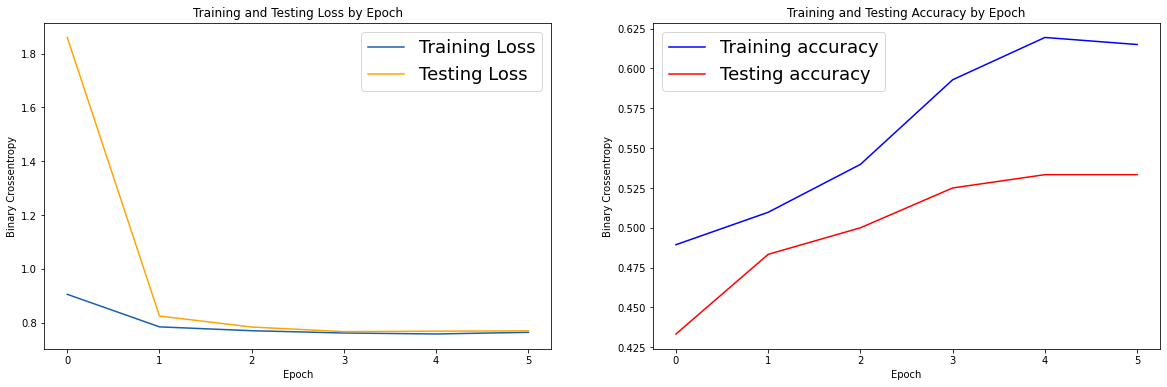

In [ ]:
# axial plane
num_epochs=20

cnn_model=create_model()
axl_men_model, alex_axl_men = build_model(cnn_model,'alex_axl_men', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
alex_axl_men_acc=[]
alex_axl_men_acc.append(np.mean(alex_axl_men.history['val_accuracy']))
plot_results(alex_axl_men)

Epoch 1/20
36/36 [==============================] - 2s 29ms/step - loss: 0.8049 - accuracy: 0.5735 - val_loss: 0.7891 - val_accuracy: 0.4333
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7504 - accuracy: 0.6248 - val_loss: 0.7625 - val_accuracy: 0.5583
Epoch 3/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7555 - accuracy: 0.6204 - val_loss: 0.7635 - val_accuracy: 0.5583
Epoch 4/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7554 - accuracy: 0.6389 - val_loss: 0.7608 - val_accuracy: 0.5667
Epoch 5/20
36/36 [==============================] - 1s 22ms/step - loss: 0.7481 - accuracy: 0.6354 - val_loss: 0.7629 - val_accuracy: 0.5667
Epoch 6/20
36/36 [==============================] - 1s 21ms/step - loss: 0.7392 - accuracy: 0.6310 - val_loss: 0.7631 - val_accuracy: 0.5667


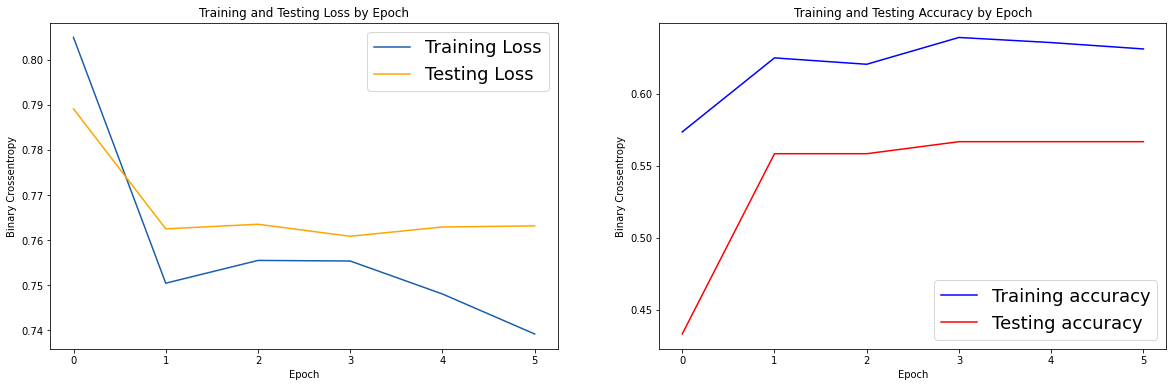

In [ ]:
# sagittal plane
num_epochs=20

cnn_model=create_model()
sag_men_model, alex_sag_men = build_model(cnn_model,'alex_sag_men', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
alex_sag_men_acc=[]
alex_sag_men_acc.append(np.mean(alex_sag_men.history['val_accuracy']))
plot_results(alex_sag_men)

**calculate average accuracy**

In [ ]:
[alex_cor_men_acc, alex_axl_men_acc, alex_sag_men_acc]

[[0.5430555492639542], [0.501388892531395], [0.5416666666666666]]

### Evaluate results

In [ ]:
cor_men_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cor_men_scores[0]) 
print('Test accuracy:', cor_men_scores[1])

Test loss: 0.7675246596336365
Test accuracy: 0.5583333373069763


In [ ]:
axl_men_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', axl_men_scores[0]) 
print('Test accuracy:', axl_men_scores[1])

Test loss: 0.7694900631904602
Test accuracy: 0.5333333611488342


In [ ]:
sag_men_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', sag_men_scores[0]) 
print('Test accuracy:', sag_men_scores[1])

Test loss: 0.7631429433822632
Test accuracy: 0.5666666626930237


In [ ]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/alex_cor_men//alexnet_model.h5')
cor_pred = saved_cor_model.predict(coronal_mensicus_val) 

In [ ]:
saved_axl_model = load_model(f'{path_dir}/alex_axl_men//alexnet_model.h5')
axl_pred = saved_axl_model.predict(axial_mensicus_val) 

In [ ]:
saved_sag_model = load_model(f'{path_dir}/alex_sag_men//alexnet_model.h5')
sag_pred = saved_sag_model.predict(sagittal_mensicus_val)

In [ ]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [ ]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.473110
1      0.491408
2      0.498074
3      0.478803
4      0.480102
         ...   
115    0.485496
116    0.482136
117    0.474829
118    0.477693
119    0.480333
Name: mean, Length: 120, dtype: float32

In [ ]:
pred_men['mean'] = pred_men.mean(axis=1)

In [ ]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [ ]:
pred_men['predict'].value_counts()

0    116
1      4
Name: predict, dtype: int64

In [ ]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [ ]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(50, 6)

In [ ]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
24,0.513261,0.764791,0.471275,0.583109,1,0
42,0.492711,0.500849,0.447351,0.480304,0,1
43,0.492711,0.494229,0.471781,0.486240,0,1
44,0.492711,0.518734,0.445179,0.485542,0,1
46,0.492711,0.508191,0.446319,0.482407,0,1
54,0.492711,0.497443,0.478373,0.489509,0,1
56,0.492711,0.474801,0.437305,0.468272,0,1
58,0.498526,0.475924,0.484771,0.486407,0,1
62,0.492711,0.495366,0.439953,0.476010,0,1
64,0.492711,0.495787,0.438063,0.475520,0,1


**export results to csv**

In [ ]:
pred_men.to_csv('/content/drive/MyDrive/alexnet_pred_men_results.csv')